# This file is used for exploring the data

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import hist
import math
import sqlite3

In [2]:
# Read in the data
courses = pd.read_csv('data/courses.csv')
assessments = pd.read_csv('data/assessments.csv')
vle = pd.read_csv('data/vle.csv')
students = pd.read_csv('data/studentInfo.csv')
student_registration = pd.read_csv('data/studentRegistration.csv')
student_assessments = pd.read_csv('data/studentAssessment.csv')
student_vle = pd.read_csv('data/studentVle.csv')

con = sqlite3.connect("data/ou.db")
cur = con.cursor()

In [51]:
test_assessments = student_assessments.copy(deep=True)

def add_time_before_deadline():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['time_before_deadline'] = joined_assessments['date_submitted'] - joined_assessments['date']
    
def drop_banked():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['is_banked'] = joined_assessments['is_banked']
    test_assessments = test_assessments[student_assessments.is_banked == 0]
    
def add_assessment_info():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['weight'] = joined_assessments['weight']
    test_assessments['TMA'] = joined_assessments['assessment_type'] == "TMA"
    test_assessments['Exam'] = joined_assessments['assessment_type'] == "Exam"
    test_assessments['CMA'] = joined_assessments['assessment_type'] == "CMA"

def add_previous_average():
    global test_assessments
    # Use a sqlite database to make some calculations a lot quicker
    cur.execute('''
    SELECT (SELECT AVG(score)
        FROM assessments
                 JOIN student_assessments ON assessments.id_assessment = assessments.id_assessment AND
                                             student_assessments.id_student = sa.id_student
        WHERE date < a.date
          AND code_module = a.code_module
          AND assessments.code_presentation = a.code_presentation)
FROM assessments a
         JOIN student_assessments sa ON a.id_assessment = sa.id_assessment;
         ''')
    test_assessments['prev_avg'] = pd.DataFrame(cur.fetchall(), columns=['avg'])['avg']

    
# One hot encoding for assessment type
add_time_before_deadline()
drop_banked()
add_assessment_info()
add_previous_average()

test_assessments.head()

# total days worked on, total time worked on, last average


,id_assessment,id_student,date_submitted,is_banked,score,time_before_deadline,weight,TMA,Exam,CMA,prev_avg
0,1752,11391,18,0,78.0,-1.0,10.0,True,False,False,NaN
1,1752,28400,22,0,70.0,3.0,10.0,True,False,False,NaN
2,1752,31604,17,0,72.0,-2.0,10.0,True,False,False,NaN
3,1752,32885,26,0,69.0,7.0,10.0,True,False,False,NaN
4,1752,38053,19,0,79.0,0.0,10.0,True,False,False,NaN


102281


(array([  52.,    3.,    7.,    3.,    6.,    3.,    6.,    5.,    6.,
           6.,   13.,   11.,    9.,    7.,   11.,   17.,   11.,   22.,
          25.,   17.,   68.,   25.,   29.,   26.,   31.,   36.,   22.,
          25.,   48.,   42.,   72.,   45.,   21.,   57.,   31.,   55.,
          56.,   49.,   98.,   62.,  321.,   53.,  108.,   71.,  117.,
         131.,   99.,  124.,  143.,  113.,  283.,  118.,  160.,  165.,
         188.,  229.,  270.,  198.,  272.,  214.,  949.,  235.,  336.,
         279.,  324.,  480.,  333.,  408.,  460.,  418.,  753.,  385.,
         568.,  519.,  523.,  691.,  517.,  463.,  820.,  448., 2086.,
         488.,  563.,  604.,  639.,  710.,  656.,  548.,  579.,  530.,
         700.,  393.,  502.,  430.,  474.,  329.,  350.,  214.,  258.,
          94.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.

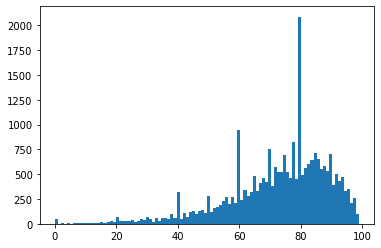

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer

test_assessments = test_assessments.dropna()
test_assessments = test_assessments[test_assessments.score != 100]
X = test_assessments
X = X.drop(["id_assessment", "id_student", "is_banked", "score", "date_submitted"], axis=1)

y = test_assessments.score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train))
hist(y_test, bins=100)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

models = [
    #LinearRegression(),
    RandomForestClassifier(random_state=0)
]

for model in models:
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    print(math.sqrt(mean_squared_error(y_test, y_prediction)))
    hist(y_prediction, bins=100)